In [1]:
import pathlib
import pickle
import platform
import warnings

import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from theano import shared

import arviz as ar
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams

In [2]:
ar.style.use('arviz-darkgrid')

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

### <u>Package Versions<u>

In [5]:
def pkg_ver(pkgs):
    print('Python & Package Versions')
    print('----------------')
    print(f'PYTHON: {platform.python_version()}')
    for pki in pkgs:
        print(f'{pki.__name__}: {pki.__version__}')
pkg_ver([np, pd, pm, ar])

Python & Package Versions
----------------
PYTHON: 3.7.3
numpy: 1.17.3
pandas: 0.25.0
pymc3: 3.7
arviz: 0.5.1


### <u>Overview</u>

In this and [a subsequent notebook](), I implement bayesian regression models to predict chlorophyll from satellite and ancillary data. Each implementation follows the sequence below.

* The model is cast in a Bayesian framework using a probabilistic programming language (PPL);
* A set of prior predictive simulations is conducted to ascertain that model priors are reasonable;
* The model is fit using the No U-Turn Sampler (NUTS) variant of Hamiltonian Monte Carlo, and the data subset from NOMAD 2008;
* Model predictive skill and  uncertainty are quantified via posterior distribution evaluation and posterior predictive simulation.

In a [third notebook](), the skill of the models are compared using Information Criteria (IC) based methods. These include Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave-One-Out Cross Validation (LOO).

### <u>The Present Notebook's Linear Models</u>
I include 4 models here:
1. A simple maximum-blue band ratio (*MBR*) regression model.
2. A hierarchical, partially pooled MBR model, where the data is grouped by the blue band of the MBR numerator.
3. A simple linear regression where the inputs are the principal components derived from the PCA of Rrs bands.
4. An OC4-type \\(4^{th}\\)degree polynomial regression.
$$$$

### <u>Loading the Data</u>
The data was stored previously in a [pandas dataframe](https://pandas.pydata.org). 

In [6]:
df = pd.read_pickle('./PickleJar/df_main_2_w_CI.pkl')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 26 columns):
id                4459 non-null int64
etopo2            4459 non-null float64
log_etopo2        4459 non-null float64
lat               4459 non-null float64
rrs411            4293 non-null float64
log_rrs411        4293 non-null float64
rrs443            4456 non-null float64
log_rrs443        4456 non-null float64
rrs489            4422 non-null float64
log_rrs489        4422 non-null float64
rrs510            3435 non-null float64
log_rrs510        3435 non-null float64
rrs555            3255 non-null float64
log_rrs555        3255 non-null float64
rrs670            1598 non-null float64
log_rrs670        1598 non-null float64
CI                1163 non-null float64
CI_OK             4459 non-null int64
MaxBlue           4459 non-null float64
MaxBlueBand       4459 non-null object
MaxBlueBandIdx    4459 non-null int8
mxBlue2Gr         3255 non-null float64
log_mxBlue2Gr     325

Below, I load indices generated from a train/test split procedure, stratified by the blue band used in the numerator of MBR.

In [8]:
with open('./PickleJar/train_test_indices' ,'rb') as fb:
    tt_pkl_d = pickle.load(fb)
    train_idx_no_nans = tt_pkl_d['train_idx_no_nans']
    test_idx_no_nans = tt_pkl_d['test_idx_no_nans']
    del tt_pkl_d

## <u>Multi-Band Ratio Linear Model</u>
<br>
<a id='MBRlin'/>

### A. <u>Pooled Model</u>
<br>

A pooled regression model is simply a regression on a the whole dataset without partitioning the data into distinct groups (see [next section](#MBR-hlin))

In [12]:
cols = ['log_mxBlue2Gr', 'MaxBlueBandIdx', 'log_chlor_a']
df_small_train = df.iloc[train_idx_no_nans][cols]
df_small_test = df.iloc[test_idx_no_nans][cols]

In [11]:
df_small_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 737 to 1475
Data columns (total 3 columns):
log_mxBlue2Gr     841 non-null float64
MaxBlueBandIdx    841 non-null int8
log_chlor_a       841 non-null float64
dtypes: float64(2), int8(1)
memory usage: 20.5 KB


In [14]:
df_small_train.MaxBlueBandIdx.value_counts()

2    418
1    221
0    202
Name: MaxBlueBandIdx, dtype: int64

In [13]:
df_small_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 1182 to 3960
Data columns (total 3 columns):
log_mxBlue2Gr     211 non-null float64
MaxBlueBandIdx    211 non-null int8
log_chlor_a       211 non-null float64
dtypes: float64(2), int8(1)
memory usage: 5.2 KB


In [16]:
X_train = df_small_train.log_mxBlue2Gr.values
y_train = df_small_train.log_chlor_a.values

In [82]:
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train_s = sc_x.fit_transform(X_train[:, None]).ravel()
y_train_s = sc_y.fit_transform(y_train[:, None]).ravel()

In [85]:
x_test_s = sc_x.transform(df_small_test.log_mxBlue2Gr.values[:, None]).ravel()
y_test_s = sc_y.transform(df_small_test.log_chlor_a.values[:, None]).ravel()

In [72]:
with pm.Model() as mbr_linear_pooled:
    data = pm.Data('data', x_train_s)
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    σ = pm.Exponential('σ', 1)
    μ = α + β * data
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_train_s)

In [183]:
mlp_graph = pm.model_to_graphviz(mbr_linear_pooled)
mlp_graph.render(filename='mdl1', directory='./resources', format='png',
                quiet=True);

<img src='./resources/mdl1.png?=2' />

In [74]:
with mbr_linear_pooled:
    prior_mlp = pm.sample_prior_predictive()
    trace_mlp = pm.sample(2000, tune=1000)
    post_mlp = pm.sample_posterior_predictive(trace_mlp)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
100%|██████████| 8000/8000 [00:11<00:00, 721.89it/s]


In [75]:
mlp_struct = ar.from_pymc3(trace=trace_mlp,
                           prior=prior_mlp,
                           posterior_predictive=post_mlp)

mlp_struct.to_netcdf('./ModelResults/mbr_linear_pooled.nc')

'./ModelResults/mbr_linear_pooled.nc'

In [108]:
def plot_data(x, y, **kwargs):
    c = kwargs.pop('c', [[1, 0, 0, 0.35]])
    edgecolor = kwargs.pop('edgecolor', 'k')
    label = kwargs.pop('label', 'true')
    zorder = kwargs.pop('zorder', 3)
    pl.scatter(x, y, c=c, edgecolor=edgecolor, 
               label=label, zorder=zorder)
    
def plot_priors(prior_, X_s, y_s, model_centric=True):
    x_idx = np.argsort(X_s)
    pl.title('Pooled Linear Model Prior Analysis')
    pl.scatter(X_s[x_idx], y_s[x_idx], c=[[1, 0, 0, 0.35]], 
               edgecolor='k', 
               label='true', 
               #alpha=0.65, 
               zorder=3
              )
    if model_centric:
        prior_realizations = prior_['β'][:, None] * X_s + prior_['α'][:, None]
        pl.plot(X_s[x_idx], prior_realizations[0, x_idx].T, color='k',
                alpha=0.1, label='prior model realizations')
        pl.plot(X_s[x_idx], prior_realizations[1:, x_idx].T, color='k',
                alpha=0.1,)
    else:
        mean_prior_y = prior_['likelihood'].mean(axis=0)
        hdi_prior_y = ar.hpd(prior_['likelihood'])
        pl.scatter(X_s[x_idx], mean_prior_y[x_idx], color='k',
               label='prediction mean', zorder=2)
        pl.fill_between(X_s[x_idx], hdi_prior_y[x_idx, 0], hdi_prior_y[x_idx, 1],
                       alpha=0.5, label='model prediction 94%HDI')
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='upper center');

    
def plot_posteriors(post_, trace_, X_s, y_s, model_centric=True, num_pred=500):
    x_idx = np.argsort(X_s)
    pl.title('Pooled Linear Model Posterior Analysis')
    #pl.scatter(X_s[x_idx], y_s[x_idx], c=[[1, 0, 0, 0.35]], edgecolor='k',
    #          label='true', alpha=0.65, zorder=3)
    plot_data(X_s[x_idx], y_s[x_idx])
    if model_centric:
        realization_idcs = np.random.choice(np.arange(1, 8000, dtype='int'), 
                                            size=500, replace=False)
        post_realizations = trace_['β'][:, None] * X_s + trace_['α'][:, None]
        pl.plot(X_s[x_idx], post_realizations[0, x_idx].T, color='k', 
                alpha=0.1, label='posterior_model realizations')
        pl.plot(X_s[x_idx], 
                post_realizations[realization_idcs[:, None], x_idx[None,:]].T,
               color='k', alpha=0.1)
    else:
        mean_post_y = post_['likelihood'].mean(axis=0)
        hdi_post_y = ar.hpd(post_['likelihood'])
        pl.scatter(X_s[x_idx], mean_post_y[x_idx], color='k',
               label='prediction mean', zorder=2)
        pl.fill_between(X_s[x_idx], hdi_post_y[x_idx, 0], hdi_post_y[x_idx, 1],
                       alpha=0.5, label='model prediction 94%HDI')
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='lower left');

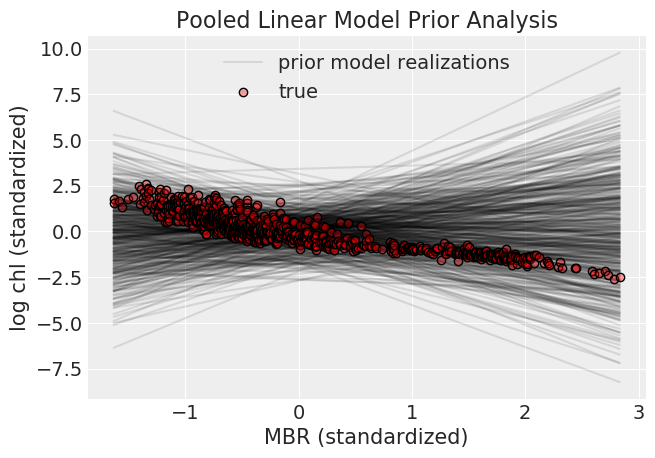

In [76]:
plot_priors(prior_mlp, x_train_s.ravel(), y_train_s.ravel())

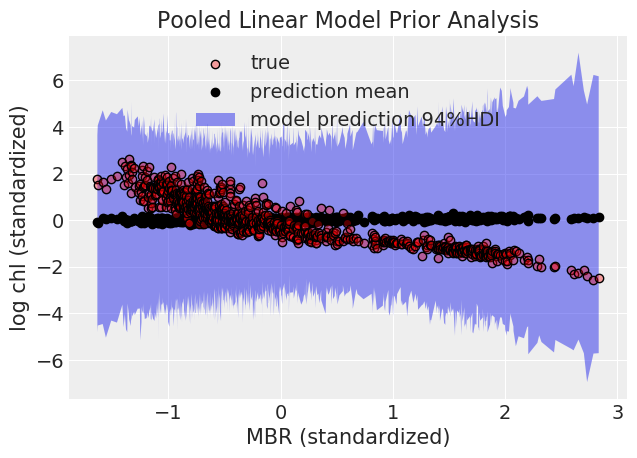

In [77]:
plot_priors(prior_mlp, x_train_s.ravel(), y_train_s, model_centric=False)

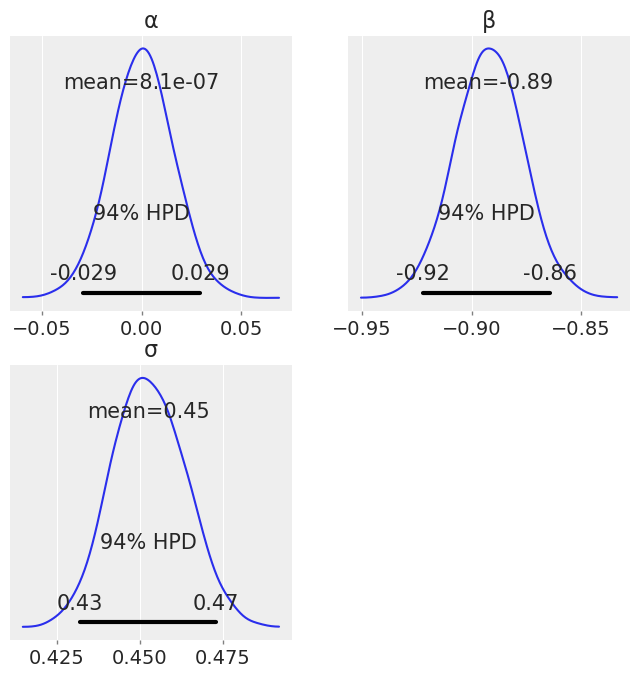

In [78]:
_, ax = pl.subplots(ncols=2, nrows=2, figsize=(8, 8))
ar.plot_posterior(mlp_struct, ax=ax)
ax.ravel()[-1].set_visible(False)

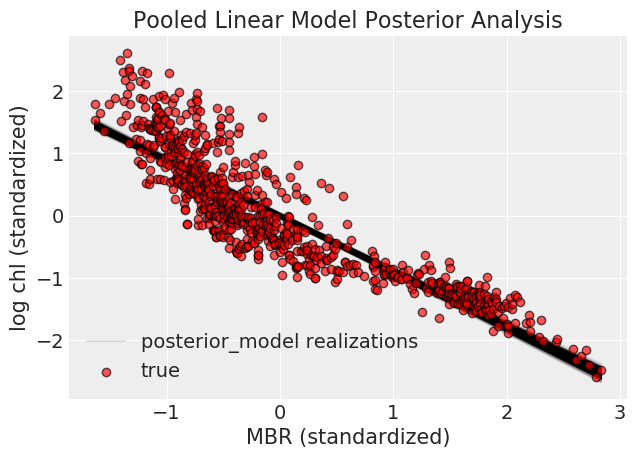

In [79]:
plot_posteriors(post_mlp, trace_mlp, x_train_s, y_train_s)

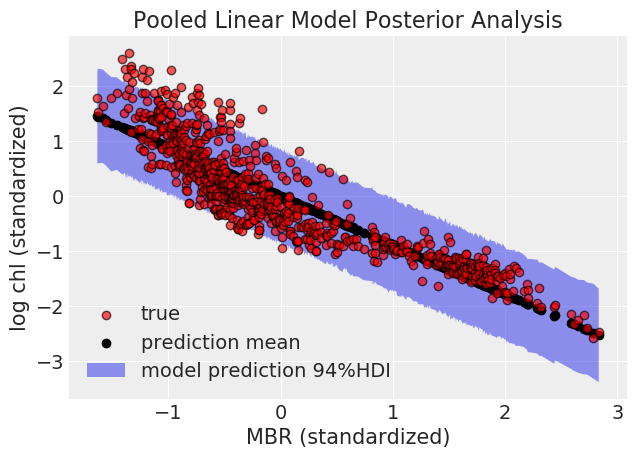

In [80]:
plot_posteriors(post_mlp, trace_mlp, x_train_s, y_train_s, model_centric=False)

Predicting out-of-sample data:

In [89]:
with mbr_linear_pooled:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    pm.set_data({'data': x_test_s})
    post_pred_mlp = pm.sample_posterior_predictive(trace_mlp, samples=500)

100%|██████████| 500/500 [00:00<00:00, 689.87it/s]


In [92]:
y_pred_s = post_pred_mlp['likelihood']

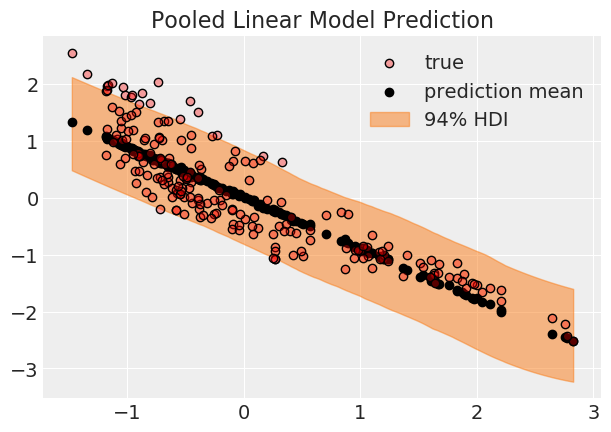

In [109]:
pl.title('Pooled Linear Model Prediction')
plot_data(x_test_s, y_test_s, )
#pl.scatter(x_test_s, y_test_s, label='true')
pl.scatter(x_test_s, y_pred_s.mean(axis=0), label='prediction mean', color='k',
           zorder=2)
ar.plot_hpd(x_test_s, y_pred_s, fill_kwargs=dict(label='94% HDI'))
pl.legend();

<a id='MBR-hlin'/>

### B. <u>Hierarchical, Partially Pooled Model</u>
<br>

The use of MBR naturally separates the data into 3 groups, based on the blue band used in the numerator of MBR. Thus the model parameters, slope and intercept will be triplicates; slopes and intercepts will each have a common hyperprior. This structure makes the model hierarchical. I will use the MaxBlueBandIdx column, where '0', '1', '2', refer to Rrs443, Rrs490, Rrs510, respectively - column to index into the 3 groups.
As a reminder, the data looks as follows:

In [110]:
df_small_train.head()

,log_mxBlue2Gr,MaxBlueBandIdx,log_chlor_a
737,-0.081201,2,0.350248
1150,-0.118369,2,0.952017
1408,0.705471,0,-0.815791
1401,0.628335,0,-0.770216
3833,-0.022982,2,-0.171340


In [158]:
# extracting group index
mbr_train_idx = df_small_train.MaxBlueBandIdx
mbr_test_idx = df_small_test.MaxBlueBandIdx

In [146]:
with pm.Model() as mbr_lin_hier:

    gp_idx = shared(np.asarray(mbr_train_idx))
    x_shared = shared(np.asarray(x_train_s))
    hyper_α_μ = pm.Normal('hyper_α_μ', 0, .1)
    hyper_α_σ = pm.HalfCauchy('hyper_α_σ', 0.1)
    hyper_β_μ = pm.Normal('hyper_β_μ', 0, 0.1)
    hyper_β_σ = pm.HalfCauchy('hyper_β_σ', 0.1)
    β = pm.Normal('β', mu=hyper_β_μ, sd=hyper_β_σ, shape=3)
    α = pm.Normal('α', mu=hyper_α_μ, sd=hyper_α_σ, shape=3)
    μ = α[(gp_idx,)] + β[(gp_idx,)] * x_shared
    σ = pm.Exponential('σ', 1)
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_train_s)

In [182]:
render = pm.model_to_graphviz(mbr_lin_hier)
render.render('mdl2', directory='./resources/', format='png');

<img src='./resources/mdl2.png?:1' />

In [148]:
with mbr_lin_hier:
    prior_mlh = pm.sample_prior_predictive()

In [154]:
tab10 = cm.get_cmap('tab10')(np.linspace(0, 1, 10))
tab10[:,-1] = 0.35
c = tab10[mbr_train_idx]
l = tab10[:3]
c[:, -1] = 0.35
l[:, -1] = 0.05
labels = ['Rrs443', 'Rrs489', 'Rrs510']

In [155]:
def plot_prior_hier(prior_predictive, X_s, y_s, mbr_idx):
    pl.figure(figsize=(8,6))
    for i in range(3):
        xi = X_s[mbr_idx==i][None, :]
        yi = y_s[mbr_idx==i]
        ci = c[mbr_idx==i]
        li = l[i]
        ai = prior_predictive['α'][:, i][:, None]
        bi = prior_predictive['β'][:, i][:, None]
        prior_realizations = ai + bi * xi
        pl.scatter(xi, yi, c=ci, edgecolor='k', 
                   label=labels[i], zorder=3)
        pl.plot(xi.T, prior_realizations[0], c=l[i], 
                label=f' model prior ({labels[i]})', alpha=0.1)
        pl.plot(xi.T, prior_realizations[10:].T, c=l[i],)
    pl.ylim(-3.3, 3.3)
    leg = pl.legend(ncol=2, facecolor='white', framealpha=1,
                   loc='lower left')
    for l_ in leg.get_lines():
        l_.set_alpha(1)

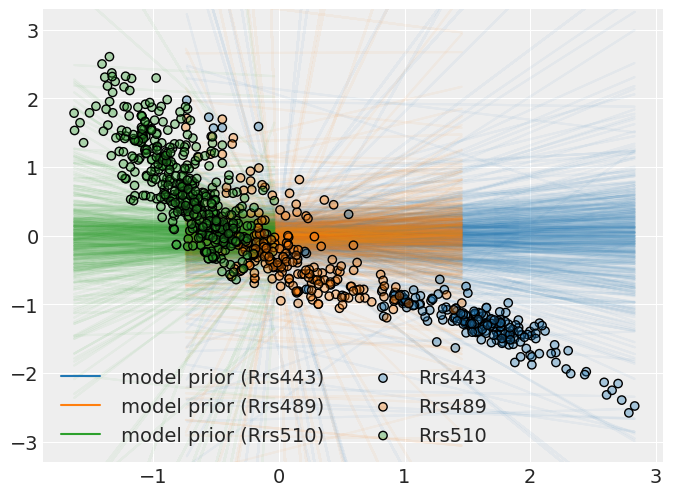

In [156]:
plot_prior_hier(prior_mlh, x_train_s, y_train_s, mbr_train_idx)

In [157]:
with mbr_lin_hier:
    trace_mlh = pm.sample(2000, tune=1000)
    post_mlh = pm.sample_posterior_predictive(trace_mlh)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, α, β, hyper_β_σ, hyper_β_μ, hyper_α_σ, hyper_α_μ]
100%|██████████| 8000/8000 [00:05<00:00, 1363.54it/s]


In [159]:
mlh_struct = ar.from_pymc3(trace=trace_mlh,
                           prior=prior_mlh,
                           posterior_predictive=post_mlh)

mlh_struct.to_netcdf('./ModelResults/mbr_linear_hier.nc')

'./ModelResults/mbr_linear_hier.nc'

In [160]:
np.tile(labels,2)

array(['Rrs443', 'Rrs489', 'Rrs510', 'Rrs443', 'Rrs489', 'Rrs510'],
      dtype='<U6')

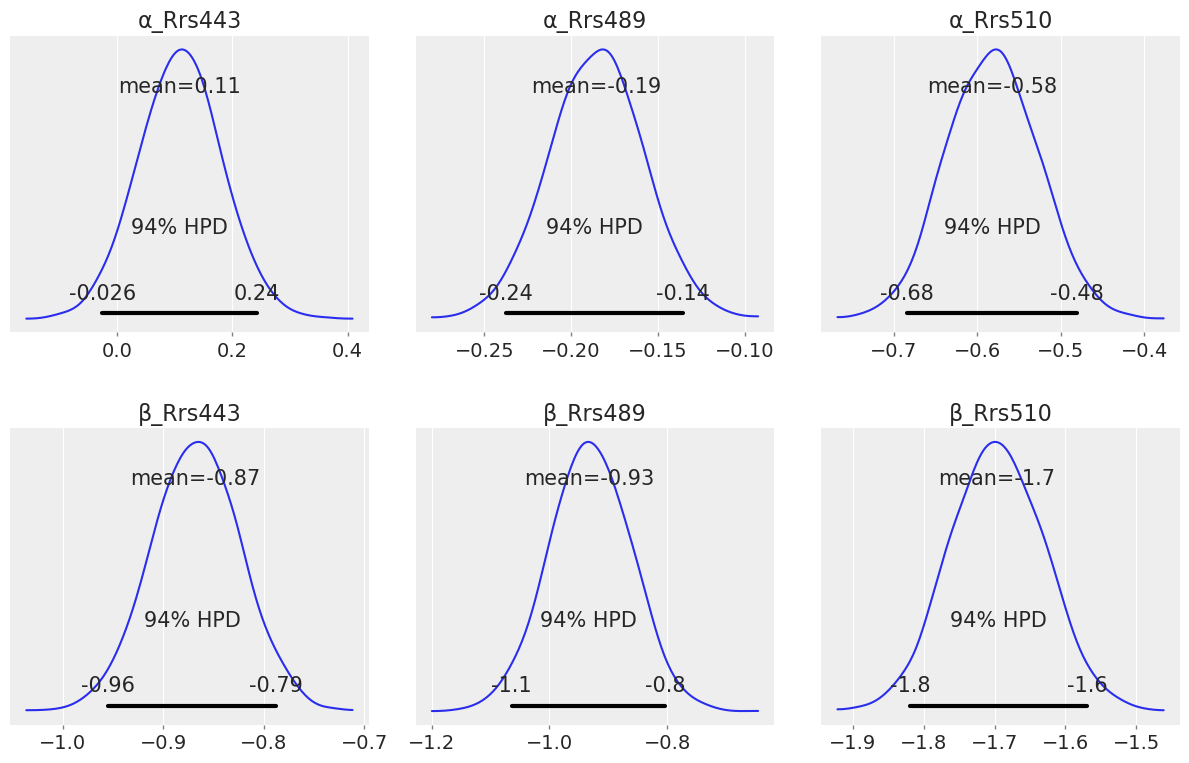

In [161]:
f, axs = pl.subplots(ncols=3, nrows=2,figsize=(12, 8))
ar.plot_posterior(mlh_struct, var_names=['α', 'β'], ax=axs);
f.tight_layout()
for ax, lbl in zip(axs.ravel(), np.tile(labels, 2)):
    ax.set_title(f'{ax.get_title()[0]}_{lbl}')

In [168]:
## Plot Posterior Analysis
def plot_posterior_hier(X_s, y_s, trace, mbr_idx):
    scatter_alpha = 0.3
    line_alpha = 0.01

    pl.figure(figsize=(8,6))
    for i in range(3):
        xi = X_s[mbr_idx==i][None, :]
        yi = y_s[mbr_idx==i]
        ci = c[mbr_idx==i]
        ci[:, -1] = scatter_alpha
        li = l[i]
        li[-1] = line_alpha
        ai = trace['α'][:, i][:, None]
        bi = trace['β'][:, i][:, None]
        post_realizations = ai + bi * xi
        choice_idx = np.random.choice(np.arange(8000, dtype='int'), 200, replace=False)
        pl.scatter(xi, yi, c=ci, edgecolor='k', 
                   label=f'obs. {labels[i]}', #zorder=3
                  )
        pl.plot(xi.T, post_realizations[0], c=li, 
                label=f' model fit ({labels[i]})', alpha=0.1)
        pl.plot(xi.T, post_realizations[choice_idx].T, c=li,)
    pl.ylim(-3.3, 3.3)
    leg = pl.legend(ncol=2, facecolor='white', framealpha=1,
                   loc='lower left')
    for l_ in leg.get_lines():
        l_.set_alpha(1)
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')

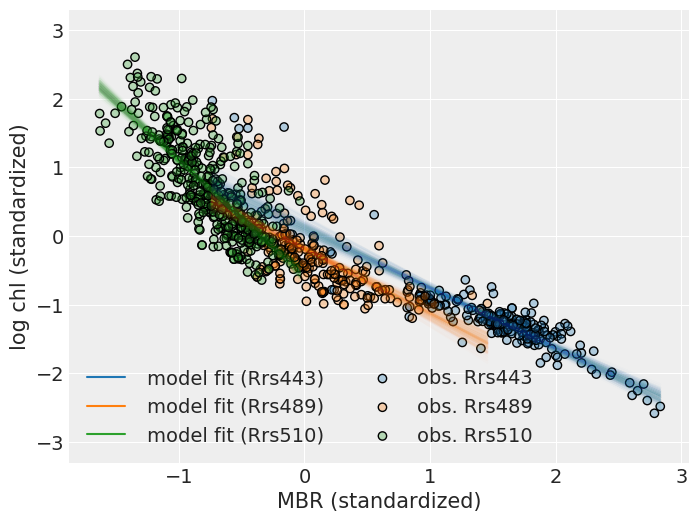

In [169]:
plot_posterior_hier(x_train_s, y_train_s, trace_mlh, mbr_train_idx)

In [171]:
with mbr_lin_hier:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    gp_idx.set_value(mbr_test_idx)
    x_shared.set_value(x_test_s)
    post_pred_mlh = pm.sample_posterior_predictive(trace_mlh, samples=500)

100%|██████████| 500/500 [00:00<00:00, 696.58it/s]


In [172]:
y_pred_s_mlh = post_pred_mlh['likelihood']

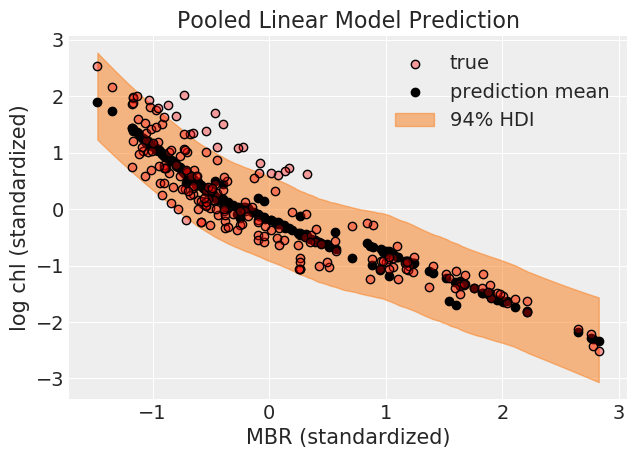

In [177]:
pl.title('Pooled Linear Model Prediction')
plot_data(x_test_s, y_test_s, label='true')
#pl.scatter(x_test_s, y_test_s, label='true')
pl.scatter(x_test_s, y_pred_s_mlh.mean(axis=0), label='prediction mean', color='k',
           zorder=2)
ar.plot_hpd(x_test_s, y_pred_s_mlh, fill_kwargs=dict(label='94% HDI'))
pl.legend();
pl.ylabel('log chl (standardized)')
pl.xlabel('MBR (standardized)');

<a id="oc4"/>

### C. <u>OC4-type \\(4^{th}\\) degree polynomial regression</u>


$$log(chl) = \alpha + \sum^4_{i=1}\beta_i  X^i$$
where
$$ X = \frac{max\left(log(Rrs443), log(Rrs489), log(Rrs510)\right)}{log(Rrs555)}$$


In [178]:
x_train_s_poly = np.c_[x_train_s, np.power(x_train_s, 2), 
                       np.power(x_train_s, 3), np.power(x_train_s, 4)]
x_test_s_poly = np.c_[x_test_s, np.power(x_test_s, 2),
                      np.power(x_test_s, 3), np.power(x_test_s, 4)]

In [180]:
with pm.Model() as mbr_oc4:
    data = pm.Data('data', x_train_s_poly)
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1, shape=4)
    σ = pm.Exponential('σ', 1)
    μ = α + pm.math.dot(data, β)
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_train_s)

In [181]:
render = pm.model_to_graphviz(mbr_oc4)
render.render('mdl3', directory='./resources/', format='png');

<img src='./resources/mdl3.png'/>

In [185]:
with mbr_oc4:
    prior_oc4 = pm.sample_prior_predictive()    

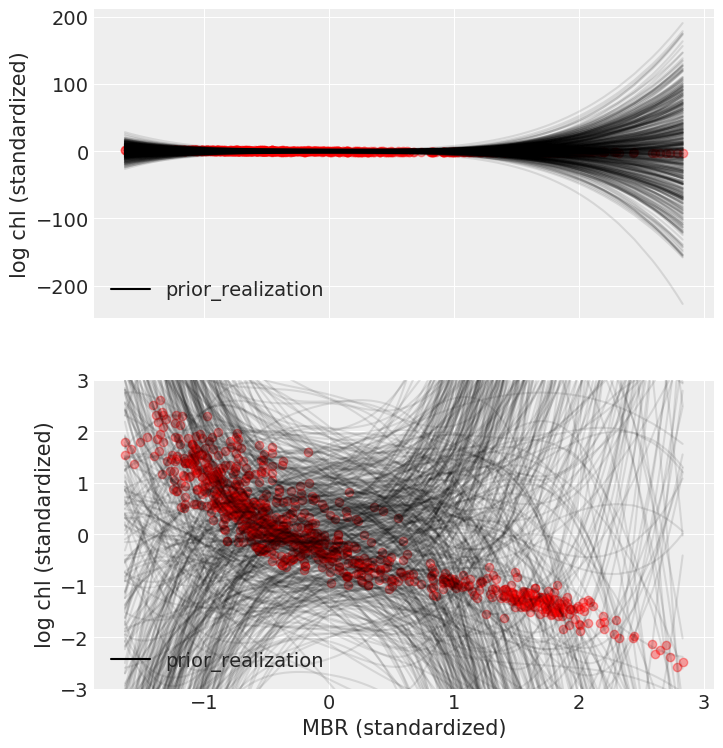

In [228]:
f, axs = pl.subplots(nrows=2, figsize=(8, 9), sharex=True)
x_idx = np.argsort(x_train_s)
for axi in axs:
    axi.scatter(x_train_s[x_idx], y_train_s[x_idx], c= [[1, 0, 0, 0.35]])
    axi.plot(x_train_s[x_idx], prior_realizations[x_idx, 0], color='k', alpha=0.1,
           label='prior_realization')
    axi.plot(x_train_s[x_idx], prior_realizations[x_idx, 1:], color='k', alpha=0.1);
    leg = axi.legend(ncol=2, facecolor='white', framealpha=1,
                   loc='lower left')
    for l_ in leg.get_lines():
        l_.set_alpha(1)
    axi.set_ylabel('log chl (standardized)')
axi.set_xlabel('MBR (standardized)');
axi.set_ylim(-3, 3);

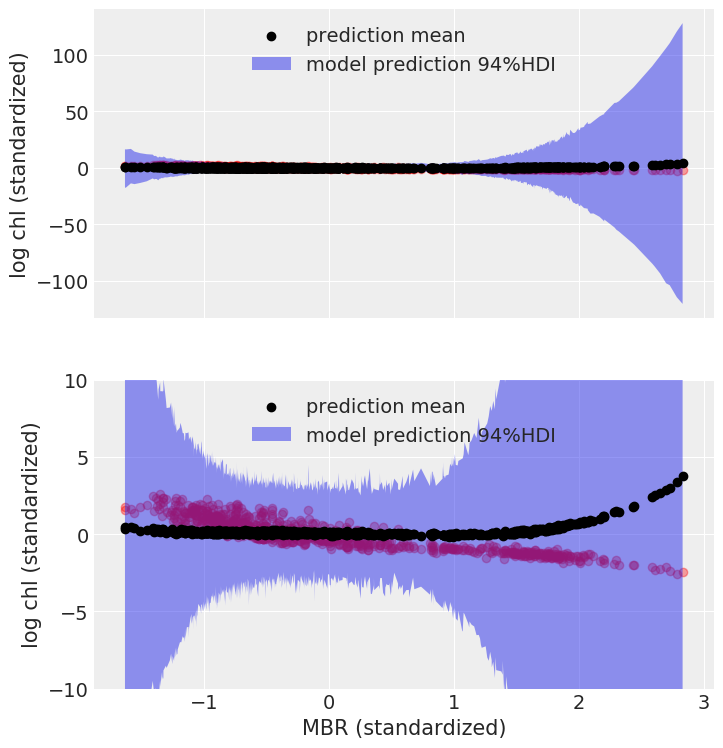

In [234]:
f, axs = pl.subplots(nrows=2, figsize=(8, 9), sharex=True)
x_idx = np.argsort(x_train_s)
mean_prior_y = prior_oc4['likelihood'].mean(axis=0)
hdi_prior_y = ar.hpd(prior_oc4['likelihood'])
x_idx = np.argsort(x_train_s)
for axi in axs:
    axi.scatter(x_train_s[x_idx], y_train_s[x_idx], c= [[1, 0, 0, 0.35]])
    axi.scatter(x_train_s[x_idx], mean_prior_y[x_idx], color='k',
           label='prediction mean', zorder=2)
    axi.fill_between(x_train_s[x_idx], hdi_prior_y[x_idx, 0], hdi_prior_y[x_idx, 1],
                   alpha=0.5, label='model prediction 94%HDI')
    axi.set_ylabel('log chl (standardized)')
    axi.legend(loc='upper center');
axi.set_xlabel('MBR (standardized)');
axi.set_ylim(-10, 10);

In [ ]:
with mbr_oc4:
    trace_oc4 = pm.sample(2000, tune=1000)
    post_oc4 = pm.sample_posterior_predictive(trace_oc4)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]

Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

---
End of this Notebook